# Genetic Algorithms (first trial)

### Plan

- Make some workers
- Set a population size 
- make them randomly go through the routes 
- Create location instances 

** ALSO, routes must include origin**


Functions:
- A function that calculates distance between two points


In [1]:
from typing import List
from random import sample

class Location:
    def __init__(self, location_name, x, y):
        self.location_name = location_name
        self.x = x 
        self.y = y
    
    def __str__(self):
         return self.location_name
    
    def __repr__(self):
        return self.location_name

class Traveller:
    def __init__(self, name, parent=None):
        self.route = None
        self.name = f"TR({name})"
        self.parent = parent
    
    def __str__(self):
         return f"Traveller({self.name})"
    
    def __repr__(self):
        return f"Traveller({self.name})"
    
    def set_random_route(self, locations: List[Location]) -> None:
        """
        Creates a randomised route that takes a traveller from home and back again. 
        """
        randomised_route = sample(locations, len(locations))
        self.route = [origin] + randomised_route + [origin]
    
    def route_total(route: List[Location]) -> float:
        if self.route == None or len(self.route) < 2: 
            return 0

        total_distance = 0
        for i in range(0, len(route)-1):
            total_distance += calculate_distance(route[i], route[i+1])
        return total_distance

In [2]:
'''
List of locations
'''

origin = Location("home", 0, 0)

locations = [
    Location('1. chinatown', 4, 4),
    Location('2. piccadilly circus', 2, 2),
    Location('3. oxford circus', 3, 6),
    Location('4. covent garden', 6, 2),
    Location('5. holborn', 8, 4),
    Location('6. tottenham court road', 6, 6),
    Location('7. charing cross', 4, 1)
]

In [3]:
'''
Some utilities
'''
import math

def calculate_distance(loc_1, loc_2: Location) -> float:
    """
    calculates the distance between two points and returns a float
    """
    x_diff = abs(loc_1.x - loc_2.x)
    y_diff = abs(loc_1.y - loc_2.y)
    
    return math.sqrt(x_diff**2 + y_diff**2)

some_route = [
    origin,
    Location("somewhere",3,4),
    Location("here",2,2),
    origin
]

def calc_route_total_distance(route: List[Location]) -> float:
    if len(route) < 2:
        raise Exception("route is too short")
    
    total_distance = 0
    for i in range(0, len(route)-1):
        total_distance += calculate_distance(route[i], route[i+1])
    return total_distance

calc_route_total_distance(some_route)

10.06449510224598

# Initial population

In [4]:
"""
Set a population size and generate some routes for them
"""
from typing import List

GENERATION = 1

population_size = 20
travellers = []

for i in range(0,population_size):
    tr = Traveller(f"gen_{GENERATION}:{i}", None)
    tr.set_random_route(locations)
    travellers.append(tr)
#     print(f"\nTraveller {i}:")
#     list(map(lambda l: print(l.location_name), tr.route))

# Fitness

In [5]:
"""
Calculate the fitness score of each traveller's route. Essentially the efficiency by distance.

Calculate the distance from 1st location to 2nd, then 2nd to 3rd and so on, until n-1 the last location.
"""


"""
Fitness scores for all traveller routes

Let's use a softmax to give it relative weighting for selection
"""

from typing import Dict
import math
from pprint import pprint

traveller_to_distance = {}
RELEVANCY_POW = 4

# Get a mapping between the traveller and total distance to travel
for t in travellers:
    traveller_to_distance[t] = round(calc_route_total_distance(t.route), 2)

# pprint(traveller_to_distance)

"""
Get shortest relative distances from the maximum
"""
def weight_routes(traveller_to_distance: Dict[Traveller, float]) -> Dict[Traveller, float] :
    '''
    Returns a dict with travel to fitness score, demonstrating the effectiveness of each routes
    '''
    max_distance = max(list(traveller_to_distance.values()))
    min_distance = min(list(traveller_to_distance.values()))
    print("Max distance: ", max_distance)
    print("Min distance: ", min_distance)
       
    return {k: pow(max_distance/traveller_to_distance[k],RELEVANCY_POW) for k,v in traveller_to_distance.items()}

weighted_routes_mapping = weight_routes(traveller_to_distance)

# pprint(weighted_routes_mapping)

"""
Transform the scores to get probabilities for selection using softmax function
"""

def convert_to_softmax_value(loc_to_score: Dict[Location, float]):
    expo_sum_for_all = sum(list(map(lambda x: math.exp(x), list(loc_to_score.values()))))
    new_dict = {k: int(round((math.exp(v)/expo_sum_for_all)*100,0)) for k, v in loc_to_score.items()}
    return new_dict


fitness_scores = convert_to_softmax_value(weighted_routes_mapping)
# print("\nFitness scores: ")
# pprint(fitness_scores)

Max distance:  42.03
Min distance:  30.41


In [6]:
from typing import Tuple 

def get_best_result(fs: Dict[Traveller, float]) -> Tuple[Traveller, float]: 
    '''
    Returns top result
    '''
    return sorted(fitness_scores.items(), key=lambda x: x[1], reverse=True)[0]

get_best_result(fitness_scores)

(Traveller(TR(gen_1:16)), 22)

In [9]:
'''
Plot best route
'''
%matplotlib inline 

import matplotlib.pyplot as plt
from random import randint
import itertools

def plot_graph_of_traveller_route(locs: List[Location]): 
    %matplotlib inline 

    colors = [
            "red",
            "limegreen",
            "gold",
            "tomato",
            "black",
            "orange",
            "skyblue",
            "darkviolet"
        ]

    iterator = itertools.cycle(colors)

    fig, ax = plt.subplots(figsize=(7,7))
#     plt.figure(figsize=(10, 10))

    x = list(map(lambda l: l.x, best_traveller.route))
    y = list(map(lambda l: l.y, best_traveller.route))

    plt.scatter(x,y)
    
    # Annotate
    for i in range(0, len(locations)):
        location = locations[i]
        ax.annotate(location.location_name, (location.x, location.y)) 


    for i in range(0, len(x)-1):
        rc = iterator.__next__()
        x_diff_half, y_diff_half = (x[i+1] - x[i])/2, (y[i+1] - y[i])/2
        plt.arrow(x[i], y[i], x_diff_half, y_diff_half,
                  length_includes_head=True,
                  width=0.02, color=rc,
                  linestyle="dashed",
                  head_width=0.1,
                 )
        plt.arrow(x[i] + x_diff_half, y[i] + y_diff_half, x_diff_half, y_diff_half,
                  length_includes_head=True,
                  width=0.02, color=rc,
                  linestyle="dashed",
                  head_width=0.0,
                 )

    plt.xlim(0, 9)
    plt.ylim(0, 8)
    plt.grid()
    plt.show()

Best route from Traveller(TR(gen_1:16)) of distance 30.405078275192572

Displaying root below: 
home
4. covent garden
5. holborn
1. chinatown
3. oxford circus
6. tottenham court road
2. piccadilly circus
7. charing cross
home


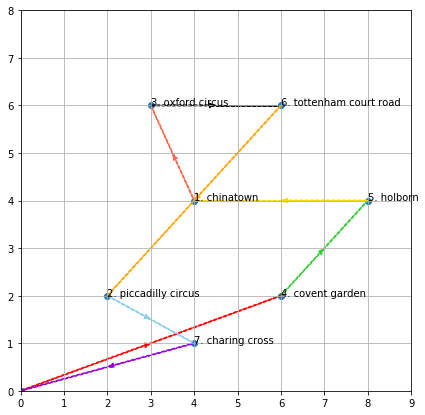

In [10]:
'''
Take a look at the best route
'''

best_traveller = get_best_result(fitness_scores)[0]
second_best = get_best_result(fitness_scores)[1]
total_distance = calc_route_total_distance(best_traveller.route)
print(f"Best route from {best_traveller} of distance {total_distance}")
print("\nDisplaying root below: ")
for l in best_traveller.route:
    print(l)
    
plot_graph_of_traveller_route(best_traveller.route)

# Selection, Crossover, Mutation

In [212]:
'''
We'll take a multipler based on the number of samples there are 

MULTIPLIER = 100 / SAMPLE SIZE
'''

def create_raffle_tickets(fitness_scores: Dict[Traveller, float], population_size: int) -> List[Traveller]:
    multiplier = 100 / population_size if population_size > 0 else 0
    print("Multiplier: ", multiplier)

    tickets = []

    for t, s in fitness_scores.items():
        for i in range(0,s):
            tickets.append(t)
    return tickets

def shuffle_locations(locs: List[Location]) -> List[Location]: 
    '''
    Cannot shuffle location if the beginning or the end 
    
    WRITE TESTS FOR THIS! EASY TO DEBUG
    '''    
    origin = Location("home", 0, 0)
#     print("Shuffling: ", locs)
#     print("first loc: ", locs[0])    
#     print("does it match: ", "home" == locs[0].location_name)
    
    if locs[0].location_name == origin.location_name:
        shuffled_locs = [origin] + sample(locs[1:], len(locs[1:]))
    elif locs[-1].location_name == origin.location_name:
        shuffled_locs = sample(locs[:-1], len(locs[:-1])) + [origin]
    else:
        shuffled_locs = sample(locs, len(locs))

    return shuffled_locs

In [358]:
'''
BEST SLICES FROM TWO PARENTS, shuffle the surrounding

'''

from random import randint, sample
from typing import List

def draw_traveller_at_random(tickets: List[int]) -> Traveller:
    return tickets[randint(0,len(tickets)-1)]

tickets = create_raffle_tickets(fitness_scores, population_size)
offspring = []

# for i in range(0, population_size):
population_size = 20 # REMOVE LATER

def find_worst_slice_index(genes: List[Location], slice_size:int):
    
    if slice_size > len(genes) - 1:
        raise Exception("Slice size exceeds genes length")
    
    first_slice = genes[0:slice_size]
    worst_slice = [0, calc_route_total_distance(first_slice)] # index, total_distance of worst slice
#     print("First worst slice: ", first_slice, "with distance: ", calc_route_total_distance(first_slice))

    for i in range(1, len(genes)-slice_size):
        route_slice = genes[i:i+slice_size]
        route_slice_distance = calc_route_total_distance(route_slice)
#         print(f"Distance from {i}: {route_slice_distance}")
        if route_slice_distance > worst_slice[1]:
            worst_slice = (i, round(route_slice_distance,1))
#     print("Worse slice: ", worst_slice)
    worst_slice_index = worst_slice[0]
    return worst_slice[0], genes[worst_slice_index:worst_slice_index+slice_size]
        
for i in range(0, population_size):
    pick = draw_traveller_at_random(tickets)
    
    random_slice_size = 3

    #Find worst slice index
    ws_index_1, worst_slice = find_worst_slice_index(pick.route, random_slice_size)
    shuffled_ws = shuffle_locations(worst_slice)
#     print(ws_index_1)
#     print(worst_slice)
  
    mutation = pick.route[:ws_index_1] + shuffled_ws + pick.route[ws_index_1+random_slice_size:] 
#     print("Parent route:")
#     pprint(pick.route)
#     print("child route:")
#     pprint(mutation)



    # ADD OFFSPRING to LIST
    GENERATION = 2
    new_child = Traveller(f"gen:{GENERATION}:{i+1}", pick)
    new_child.route = mutation
    offspring.append(new_child)

print(f"Percentage of superior: {calc_superioty_percentage(offspring)}%")

Multiplier:  5.0
new offspring:
HOW MANY ARE BETTER THAN PARENT?:
[Traveller(TR(gen:2:3)),
 Traveller(TR(gen:2:6)),
 Traveller(TR(gen:2:10)),
 Traveller(TR(gen:2:11)),
 Traveller(TR(gen:2:12)),
 Traveller(TR(gen:2:16)),
 Traveller(TR(gen:2:18)),
 Traveller(TR(gen:2:20))]
Percentage of superior: 40.0%


In [359]:
def calc_superioty_percentage(tr: List[Traveller]) -> float:
    print("new offspring:")
    print("HOW MANY ARE BETTER THAN PARENT?:")

    superior_children = []

    for o in offspring: 
    #     print(f"\noffspring name: {o.name}")
    #     print(f"TOTAL DISTANCE: {calc_route_total_distance(o.route)}")
    #     print(f"parent distance: {calc_route_total_distance(o.parent.route)}")
    #     pprint(o.route)
        if calc_route_total_distance(o.route) < calc_route_total_distance(o.parent.route):
            superior_children.append(o)

    pprint(superior_children)
    (len(superior_children)/population_size) * 100
    return (len(superior_children)/population_size) * 100

In [409]:
'''
WORST SLICE ATTEMPT from single parent 

Draw travellers up to the population size
'''

from random import randint, sample
from typing import List

def draw_traveller_at_random(tickets: List[int]) -> Traveller:
    return tickets[randint(0,len(tickets)-1)]

def is_left_side() -> bool:
    return True if randint(0,1) == 1 else False

tickets = create_raffle_tickets(fitness_scores, population_size)
offspring = []

# for i in range(0, population_size):

population_size = 20 # REMOVE LATER

def find_worst_slice_index(genes: List[Location], slice_size:int):
    
    if slice_size > len(genes) - 1:
        raise Exception("Slice size exceeds genes length")
    
    first_slice = genes[0:slice_size]
    worst_slice = [0, calc_route_total_distance(first_slice)] # index, total_distance of worst slice
#     print("First worst slice: ", first_slice, "with distance: ", calc_route_total_distance(first_slice))

    for i in range(1, len(genes)-slice_size):
        route_slice = genes[i:i+slice_size]
        route_slice_distance = calc_route_total_distance(route_slice)
#         print(f"Distance from {i}: {route_slice_distance}")
        if route_slice_distance > worst_slice[1]:
            worst_slice = (i, round(route_slice_distance,1))
#     print("Worse slice: ", worst_slice)
    worst_slice_index = worst_slice[0]
    return worst_slice[0], genes[worst_slice_index:worst_slice_index+slice_size]
        
for i in range(0, population_size):
    pick = draw_traveller_at_random(tickets)
    
    random_slice_size = 3

    #Find worst slice index
    ws_index_1, worst_slice = find_worst_slice_index(pick.route, random_slice_size)
    shuffled_ws = shuffle_locations(worst_slice)
#     print(ws_index_1)
#     print(worst_slice)
  
    mutation = pick.route[:ws_index_1] + shuffled_ws + pick.route[ws_index_1+random_slice_size:] 
#     print("Parent route:")
#     pprint(pick.route)
#     print("child route:")
#     pprint(mutation)

    GENERATION = 2
    new_child = Traveller(f"gen:{GENERATION}:{i+1}", pick)
    new_child.route = mutation
    offspring.append(new_child)


print("new offspring:")
print("HOW MANY ARE BETTER THAN PARENT?:")

superior_children = []

for o in offspring: 
#     print(f"\noffspring name: {o.name}")
#     print(f"TOTAL DISTANCE: {calc_route_total_distance(o.route)}")
#     print(f"parent distance: {calc_route_total_distance(o.parent.route)}")
#     pprint(o.route)
    if calc_route_total_distance(o.route) < calc_route_total_distance(o.parent.route):
        superior_children.append(o)

(len(superior_children)/population_size) * 100

# HOW MANY ARE BETTER THAN GENERATION 1 

winning_children = 0
for i in range(0, population_size):
    gen_1_travel = calc_route_total_distance(travellers[i].route)
    gen_2_travel = calc_route_total_distance(offspring[i].route)

    if gen_1_travel < gen_2_travel:
        winning_children += 1
        
print("Winning children total", winning_children, "out of ", population_size)

Multiplier:  5.0
new offspring:
HOW MANY ARE BETTER THAN PARENT?:
Winning children total 5 out of  20


In [82]:
'''

BEST SLICE ATTEMPT FROM SINGLE PARENT 

Draw travellers up to the population size
'''

from random import randint, sample
from typing import List

def draw_traveller_at_random(tickets: List[int]) -> Traveller:
    return tickets[randint(0,len(tickets)-1)]

def is_left_side() -> bool:
    return True if randint(0,1) == 1 else False

def create_new_generation(fitness_scores: Dict[Traveller, float], population_size) -> List[Traveller]:
    
    tickets = create_raffle_tickets(fitness_scores, population_size)
    offspring = []

    # for i in range(0, population_size):
    
    population_size = 20 # REMOVE LATER
    
    for i in range(0, population_size):
        pick = draw_traveller_at_random(tickets)
    #     print(f"Parent route: \n with total distance {calc_route_total_distance(pick.route)}")
    #     pprint(pick.route)


        #Crossover_point for slicing
        cop = randint(1, len(locations)-2)

        route_left = pick.route[1:cop]
        route_right = pick.route[cop:-1]

        if is_left_side():
            route_left = sample(route_left, len(route_left))
        else:
            route_right = sample(route_right, len(route_right))
        new_route = [origin] + route_left + route_right + [origin]

        GENERATION = 2
        new_child = Traveller(f"gen:{GENERATION}:{i+1}", pick)
        new_child.route = new_route
        offspring.append(new_child)
        
    return offspring
        
offspring = create_new_generation(fitness_scores, population_size)
        
print("new offspring:")

print("HOW MANy BETTER THAN PARENT?:")

superior_children = []

for o in offspring: 
#     print(f"\noffspring name: {o.name}")
#     print(f"TOTAL DISTANCE: {calc_route_total_distance(o.route)}")
#     print(f"parent distance: {calc_route_total_distance(o.parent.route)}")
#     pprint(o.route)
    if calc_route_total_distance(o.route) < calc_route_total_distance(o.parent.route):
        superior_children.append(o)

pprint(superior_children)
(len(superior_children)/population_size) * 100

# LOW PERCENTAGE ARE SHOWING BETTER RESULTS THAN PARENT 
# NEED TO IMPROVE MUTATION ALGORITHM

Multiplier:  5.0
new offspring:
HOW MANy BETTER THAN PARENT?:
[Traveller(TR(gen:2:1)),
 Traveller(TR(gen:2:6)),
 Traveller(TR(gen:2:7)),
 Traveller(TR(gen:2:14)),
 Traveller(TR(gen:2:15)),
 Traveller(TR(gen:2:17)),
 Traveller(TR(gen:2:20))]


35.0

In [11]:
"""
EMPTY SPACE





























"""

'\nEMPTY SPACE\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'